### Objective: 
Predict the probability of a stroke based on patient-level data

### Expected outcome: 
In this notebook, I am to produce a classification model that yields the probability of a stroke


### Data source: 
The dataset came from [**Kaggle**](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data), with its actual source remaining confidential as of writing.

In [1]:
import pandas as pd
df_stroke = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [2]:
data_info = pd.DataFrame(df_stroke.dtypes, columns=['Dtype'])
data_info['Unique'] = df_stroke.nunique().values
data_info['Null'] = df_stroke.isnull().sum().values
data_info

,Dtype,Unique,Null
id,int64,5110,0
gender,object,3,0
age,float64,104,0
hypertension,int64,2,0
heart_disease,int64,2,0
ever_married,object,2,0
work_type,object,5,0
Residence_type,object,2,0
avg_glucose_level,float64,3979,0
bmi,float64,418,201


The dataset has 5110 entries. The target variable is stroke: 1 for yes, 0 for no. There are 12 columns, 4 of which are numeric: `id`, `age`, `avg_glucose_level`, and `bmi`. But note that `id` is a unique identifier, akin to a patient number, and does not provide predictive value for the target variable and can be safely disregarded throughout the modeling. There are 9 categorical varaibles, including the target variable. 

The table `data_info` lists down the variables used in the dataset. This table shows that all but `bmi` have non-null entries. I will be imputing the null entries in `bmi` with the mean of non-null entries of `bmi`

In [3]:
from sklearn.impute import SimpleImputer

# Create an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy='mean')

# Apply the imputer to the 'bmi' column
df_stroke['bmi'] = imputer.fit_transform(df_stroke[['bmi']])

In [4]:
# Check if 'bmi' column still has null entries
df_stroke['bmi'].isnull().sum()

0

Success! There are no more null values! Next, I list down the unique values of all columns in the stroke dataset `df_stroke`.

In [5]:
for i in df_stroke.columns:
    print(f'Unique elements in {i}: {df_stroke[i].unique()}')

Unique elements in id: [ 9046 51676 31112 ... 19723 37544 44679]
Unique elements in gender: ['Male' 'Female' 'Other']
Unique elements in age: [6.70e+01 6.10e+01 8.00e+01 4.90e+01 7.90e+01 8.10e+01 7.40e+01 6.90e+01
 5.90e+01 7.80e+01 5.40e+01 5.00e+01 6.40e+01 7.50e+01 6.00e+01 5.70e+01
 7.10e+01 5.20e+01 8.20e+01 6.50e+01 5.80e+01 4.20e+01 4.80e+01 7.20e+01
 6.30e+01 7.60e+01 3.90e+01 7.70e+01 7.30e+01 5.60e+01 4.50e+01 7.00e+01
 6.60e+01 5.10e+01 4.30e+01 6.80e+01 4.70e+01 5.30e+01 3.80e+01 5.50e+01
 1.32e+00 4.60e+01 3.20e+01 1.40e+01 3.00e+00 8.00e+00 3.70e+01 4.00e+01
 3.50e+01 2.00e+01 4.40e+01 2.50e+01 2.70e+01 2.30e+01 1.70e+01 1.30e+01
 4.00e+00 1.60e+01 2.20e+01 3.00e+01 2.90e+01 1.10e+01 2.10e+01 1.80e+01
 3.30e+01 2.40e+01 3.40e+01 3.60e+01 6.40e-01 4.10e+01 8.80e-01 5.00e+00
 2.60e+01 3.10e+01 7.00e+00 1.20e+01 6.20e+01 2.00e+00 9.00e+00 1.50e+01
 2.80e+01 1.00e+01 1.80e+00 3.20e-01 1.08e+00 1.90e+01 6.00e+00 1.16e+00
 1.00e+00 1.40e+00 1.72e+00 2.40e-01 1.64e+00 1.56e+00 

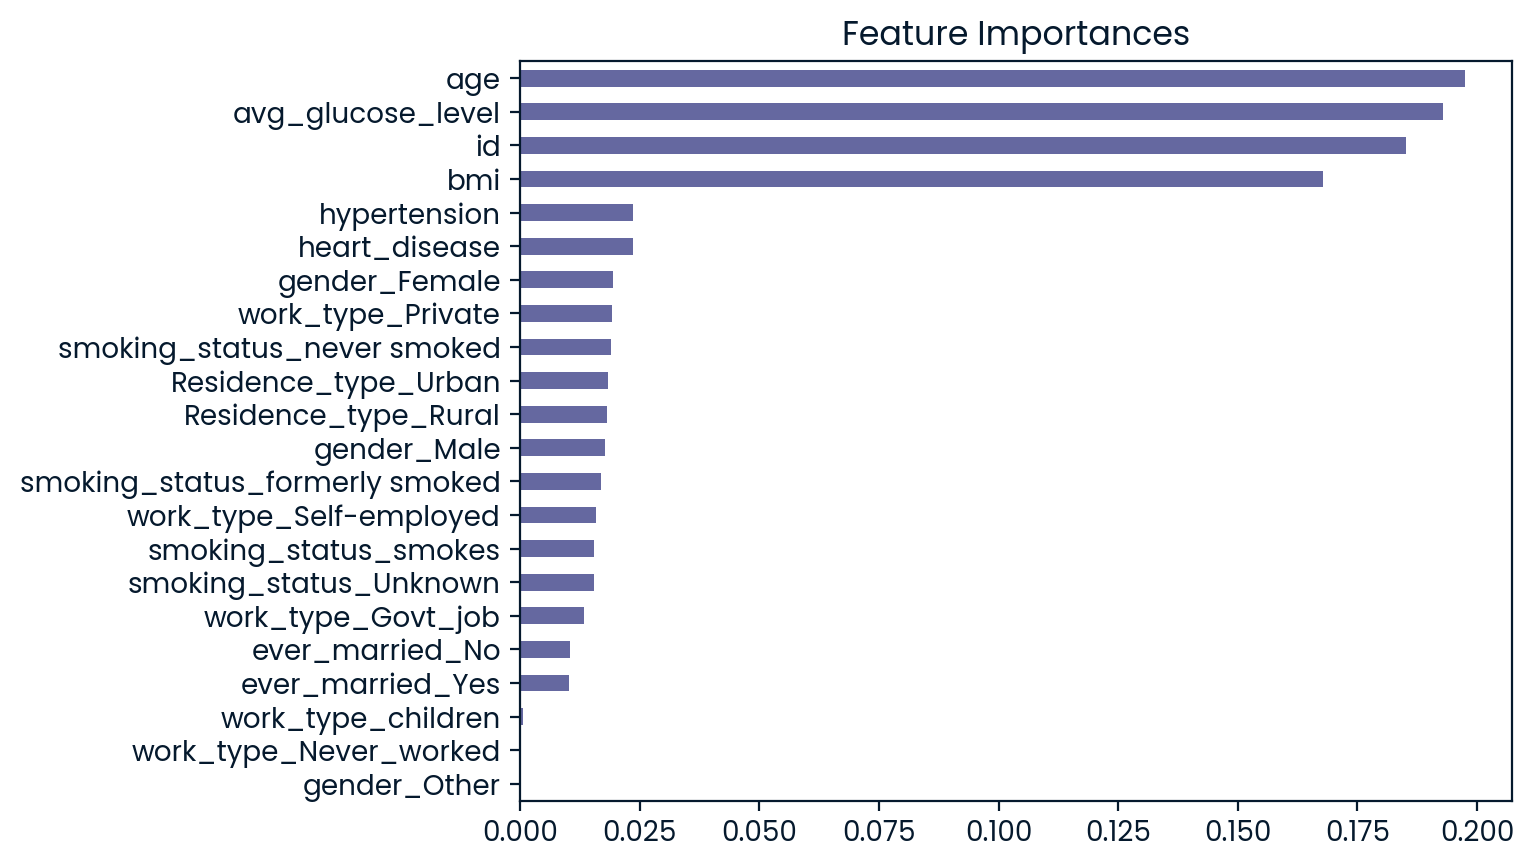

In [9]:
try:
    from skopt import BayesSearchCV
except ImportError:
    !pip install scikit-optimize 
    from skopt import BayesSearchCV
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline  # Import Pipeline
from skopt import BayesSearchCV
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Define features and target
X = df_stroke.drop('stroke', axis=1)
y = df_stroke['stroke']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(exclude=['object', 'category']).columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Create a ColumnTransformer with StandardScaler for numerical columns and OneHotEncoder for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Create a pipeline with the preprocessor and RandomForestClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Get feature importances from the RandomForestClassifier
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Combine numerical and categorical feature names
features = numerical_cols.tolist() + pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()

# Create a DataFrame for feature importances
importances = pd.Series(feature_importances, index=features)

# Get the top 10 features
top_10_features = importances.nlargest(10).index.tolist()

# Plot feature importances
importances.sort_values().plot(kind='barh')
plt.title('Feature Importances')
plt.show()

In [12]:
# looped over different number of top features

fname='./healthcare-dataset-stroke-data.csv'


def get_acc_importance(fname, tsplit=0.2, rand_seed=42, num_feat=(True, 15), nsamp=5, niter=10, opt_cv=3, save_model=(True, 'default')):
    

    # Step 1: Load the dataset and replace NaN in bmi with mean
    df = pd.read_csv(fname)
    df['bmi'].fillna(df['bmi'].mean(), inplace=True)

    # Define features and target
    X = df.drop(columns=['id', 'stroke'])
    y = df['stroke']

    # Define numerical and categorical columns
    num_cols = X.select_dtypes(exclude=['object', 'category']).columns
    cat_cols = X.select_dtypes(include=['object', 'category']).columns


    # Create the column transformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), num_cols),
            ('cat', OneHotEncoder(), cat_cols)
        ]
    )


    # Split the data into training and test sets
    X_trn, X_ts, y_trn, y_ts = train_test_split(X, y, test_size=tsplit, random_state=rand_seed, stratify=y)


    # Preprocess the data
    X_encoded = preprocessor.fit_transform(X_trn)

    
    # Get feature names after preprocessing
    feature_names = np.concatenate([num_cols, preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)])

    # Fit a RandomForest model to get feature importances
    rf = RandomForestClassifier(random_state=rand_seed)
    rf.fit(X_encoded, y_trn)

    # Get feature importances and select top X features
    importances = rf.feature_importances_


    indices = np.argsort(importances)[-1*num_feat[1]:] if (num_feat[1] < len(importances) or num_feat[0]==True) else np.argsort(importances)
    top_features = feature_names[indices]

    # Filter the dataset to include only the top X features
    # apply on the entire dataset; for comparison, in feature importance analysis, this is applied to the training set only.
    X_top = pd.DataFrame(preprocessor.fit_transform(X), columns=feature_names)[top_features]

    # Step 2: Define the models and their parameter search spaces
    models = {
        'XGBoost': (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), {
            'n_estimators': (50, 200),
            'max_depth': (3, 10),
            'learning_rate': (0.01, 0.3)
        }),
        'AdaBoost': (AdaBoostClassifier(), {
            'n_estimators': (50, 200),
            'learning_rate': (0.01, 1.0)
        }),
        'LightGBM': (lgb.LGBMClassifier(verbose=-1), {
            'n_estimators': (50, 200),
            'max_depth': (3, 10),
            'learning_rate': (0.01, 0.3)
        })
    }

    # Step 3: Perform Bayesian optimization for each model
    best_params = {}
    for model_name, (model, param_space) in models.items():
        opt = BayesSearchCV(model, param_space, n_iter=niter, cv=opt_cv, n_jobs=-1, random_state=rand_seed)
        opt.fit(X_top, y)
        best_params[model_name] = opt.best_params_

        
    # Step 4: Evaluate the best models over multiple train-test splits
    # n_splits = 5
    skf = StratifiedKFold(n_splits=nsamp, shuffle=True, random_state=rand_seed)
    accuracies = {model_name: [] for model_name in models.keys()}

    for train_index, test_index in skf.split(X_top, y):
        X_train, X_test = X_top.iloc[train_index], X_top.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for model_name, (model, _) in models.items():
            best_model = model.set_params(**best_params[model_name])
            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_test)
            accuracies[model_name].append(accuracy_score(y_test, y_pred))

    # Compute the average accuracy for each model
    average_accuracies = {model_name: np.mean(acc) for model_name, acc in accuracies.items()}

    # Select the best model
    best_model_name = max(average_accuracies, key=average_accuracies.get)
    best_model_accuracy = average_accuracies[best_model_name]
    
    bestm, _ = models[best_model_name]
    # print(type(bestm))
    # print(bestm.get_params())
    
    bestm.fit(X_encoded, y_trn)
    
    
    import joblib

    # Assuming 'model' is your trained model
    
    if save_model[0]==True:
        model_fname = "mode l.joblib"  if save_model[1] =='default' else save_model[1]
    
        joblib.dump(bestm, model_fname)    
    
    

    return best_model_name, bestm, best_model_accuracy



fname='./healthcare-dataset-stroke-data.csv'

# yields the average model accuracy of the best stroke classifier over 10 different train-test splits 
mname, bestm, macc = get_acc_importance(fname, tsplit=0.2, rand_seed=42, num_feat=(True, 15), nsamp=10, niter=5, opt_cv=3)

print(f'The average accuracy of {mname} is {macc}.')

The average accuracy of AdaBoost is 0.9500978473581212.


In [13]:
# Next, let's investigate what happens to the average model accuracy if the number of top features is changed.

macc_list = []
for i in range(1, 15+1):
    mname, bestm, macc = get_acc_importance(fname, tsplit=0.2, rand_seed=42, num_feat=(True, i), nsamp=5, niter=5, opt_cv=3)
    macc_list.append(macc)
    print(f'Done for num_feat={i}.')

Done for num_feat=1.
Done for num_feat=2.
Done for num_feat=3.
Done for num_feat=4.
Done for num_feat=5.
Done for num_feat=6.
Done for num_feat=7.
Done for num_feat=8.
Done for num_feat=9.
Done for num_feat=10.
Done for num_feat=11.
Done for num_feat=12.
Done for num_feat=13.
Done for num_feat=14.
Done for num_feat=15.


<Figure size 640x480 with 0 Axes>

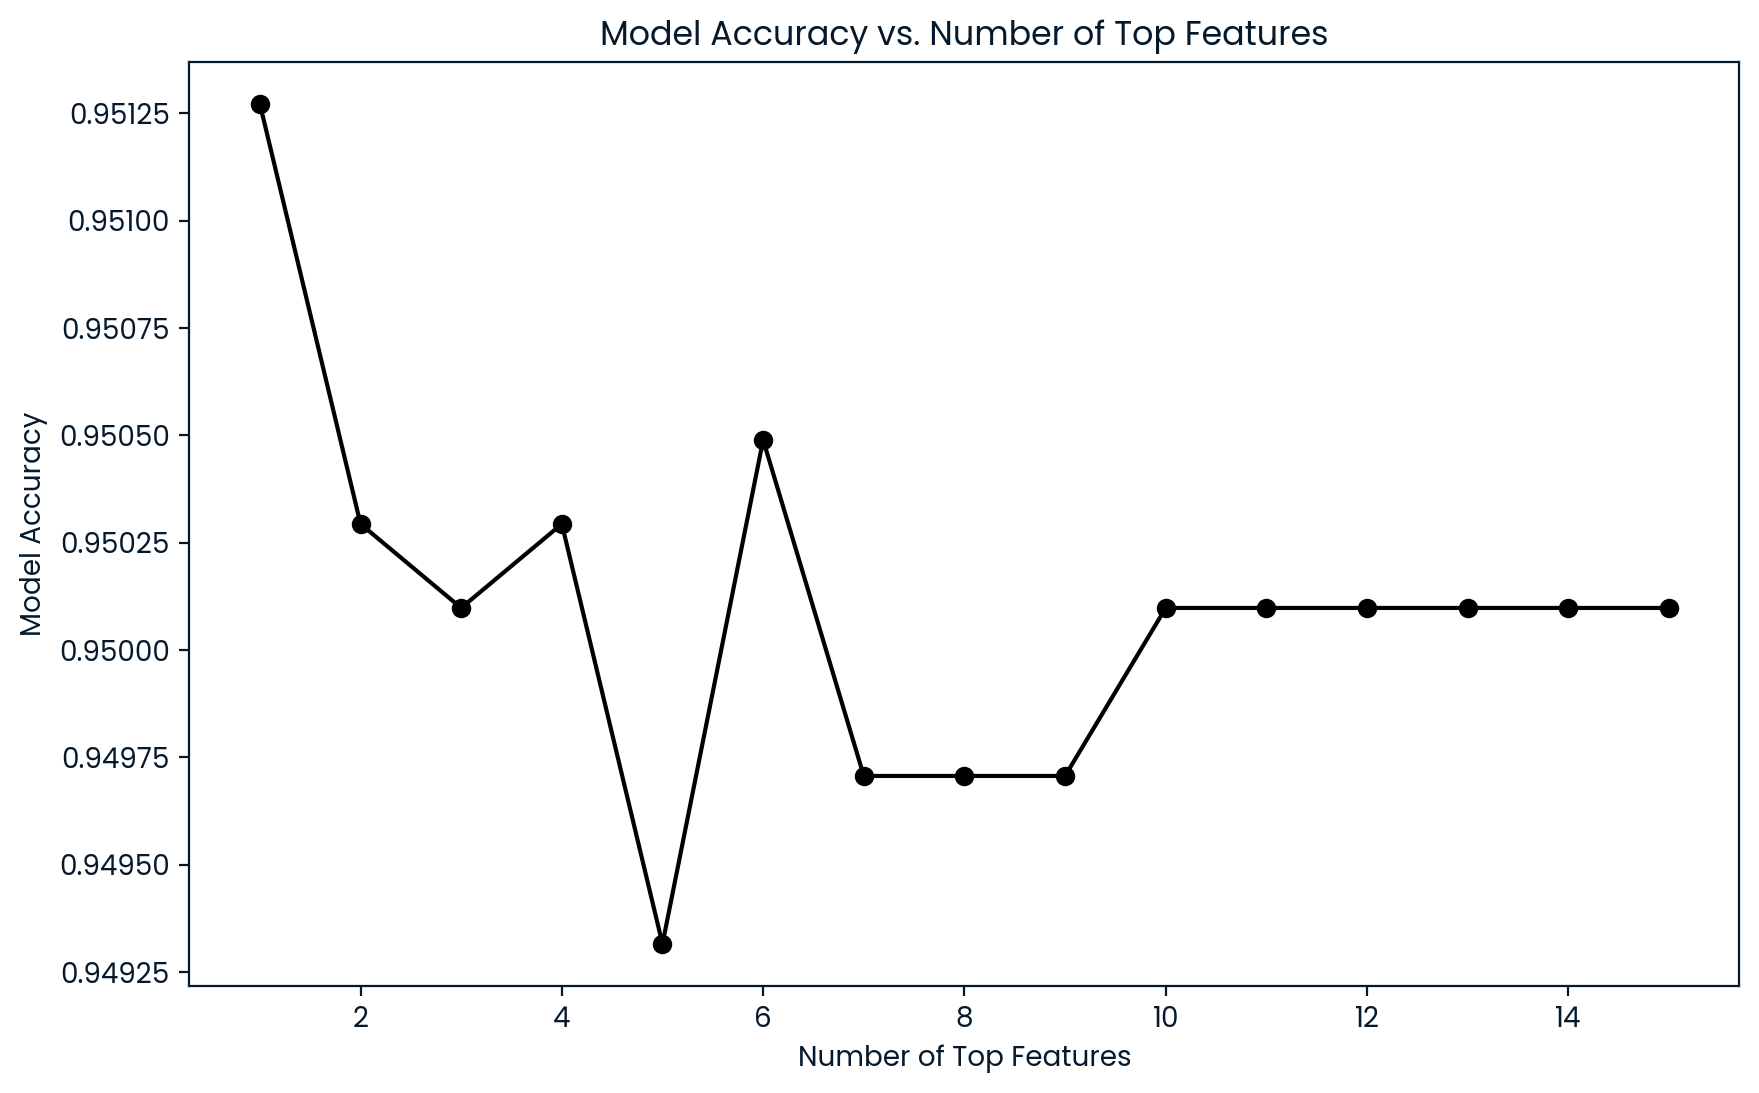

In [21]:
import matplotlib.pyplot as plt


plt.clf()
# Create a scatter plot of macc_list over range(1, 15+1)
plt.figure(figsize=(10, 6))
plt.plot(range(1, 15+1), macc_list, 'ko-') #marker='o', linestyle='-')
plt.title('Model Accuracy vs. Number of Top Features')
plt.xlabel('Number of Top Features')
plt.ylabel('Model Accuracy')
plt.show()